# SECTION 1: DEPENDENCIES AND CONFIGURATION

In [1]:
# -------------------------------------------------------------------------
# SECTION 1: DEPENDENCIES AND CONFIGURATION
# -------------------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Import DoWhy for causal inference
import dowhy
from dowhy import CausalModel
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings

# Set plots style for visualization clarity
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = [12, 8]
pd.set_option('display.max_columns', None)

print("Starting causal inference analysis using DoWhy...")

Starting causal inference analysis using DoWhy...


c:\Users\fairt\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# SECTION 2: DATA LOADING AND PREPROCESSING

In [ ]:
# -------------------------------------------------------------------------
# SECTION 2: DATA LOADING AND PREPROCESSING
# -------------------------------------------------------------------------
print("\nLoading and preprocessing data...")

# Load the dataset - assumes CSV with employee attributes and attrition flag
df = pd.read_csv('/Users/fairt/OneDrive/Desktop/Attrition.csv')

print(f"Dataset loaded with shape: {df.shape}")

# Create binary outcome variable (Attrition)
df['Attrition_Binary'] = df['Attrition'].map({'Yes': 1, 'No': 0})

# Handle categorical variables using label encoding
categorical_cols = [
    'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 
    'MaritalStatus', 'OverTime'
]

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[f"{col}_Encoded"] = le.fit_transform(df[col])
    label_encoders[col] = le
    
    # Print encoding mapping for reference
    mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(f"Encoding for {col}: {mapping}")



Loading and preprocessing data...
Dataset loaded with shape: (1470, 35)
Encoding for BusinessTravel: {'Non-Travel': np.int64(0), 'Travel_Frequently': np.int64(1), 'Travel_Rarely': np.int64(2)}
Encoding for Department: {'Human Resources': np.int64(0), 'Research & Development': np.int64(1), 'Sales': np.int64(2)}
Encoding for EducationField: {'Human Resources': np.int64(0), 'Life Sciences': np.int64(1), 'Marketing': np.int64(2), 'Medical': np.int64(3), 'Other': np.int64(4), 'Technical Degree': np.int64(5)}
Encoding for Gender: {'Female': np.int64(0), 'Male': np.int64(1)}
Encoding for JobRole: {'Healthcare Representative': np.int64(0), 'Human Resources': np.int64(1), 'Laboratory Technician': np.int64(2), 'Manager': np.int64(3), 'Manufacturing Director': np.int64(4), 'Research Director': np.int64(5), 'Research Scientist': np.int64(6), 'Sales Executive': np.int64(7), 'Sales Representative': np.int64(8)}
Encoding for MaritalStatus: {'Divorced': np.int64(0), 'Married': np.int64(1), 'Single': 

# SECTION 3: TREATMENT VARIABLE DEFINITIONS

In [3]:
# -------------------------------------------------------------------------
# SECTION 3: TREATMENT VARIABLE DEFINITIONS
# -------------------------------------------------------------------------
# Each treatment variable represents a potential causal factor affecting attrition

# 1. Overtime binary treatment
# TREATMENT ASSUMPTION: Working overtime increases stress and burnout, leading to higher attrition
df['OverTime_Binary'] = df['OverTime'].map({'Yes': 1, 'No': 0})

# 2. Work-Life Balance binary treatment 
# TREATMENT ASSUMPTION: Better work-life balance (score ≥3) reduces attrition by improving job satisfaction
df['WLB_Binary'] = df['WorkLifeBalance'].apply(lambda x: 1 if x >= 3 else 0)

# 3. Job Involvement binary treatment
# TREATMENT ASSUMPTION: Higher job involvement (score ≥3) increases organizational commitment, reducing attrition
df['JobInvolvement_Binary'] = df['JobInvolvement'].apply(lambda x: 1 if x >= 3 else 0)

# 4. Monthly Income binary treatment
# TREATMENT ASSUMPTION: Above-median income for job level reduces financial motivation to leave
# Create median income reference by job level to account for hierarchical pay structure
median_income_by_level = df.groupby('JobLevel')['MonthlyIncome'].median()
df['Above_Median_Income'] = 0
for level in median_income_by_level.index:
    level_median = median_income_by_level[level]
    mask = (df['JobLevel'] == level) & (df['MonthlyIncome'] > level_median)
    df.loc[mask, 'Above_Median_Income'] = 1

# 5. Years Since Last Promotion binary treatment
# TREATMENT ASSUMPTION: Longer time without promotion (>2 years) signals career stagnation, increasing attrition
df['Long_Time_Since_Promotion'] = df['YearsSinceLastPromotion'].apply(lambda x: 1 if x > 2 else 0)

# 6. Relationship Satisfaction binary treatment (from second implementation)
# TREATMENT ASSUMPTION: Higher relationship satisfaction improves overall wellbeing, reducing job change likelihood
df['RelationshipSatisfaction_Binary'] = df['RelationshipSatisfaction'].apply(lambda x: 1 if x >= 3 else 0)

# 7. Number of Companies Worked binary treatment (from second implementation)
# TREATMENT ASSUMPTION: Past job-changing behavior (>3 previous companies) predicts future job-changing tendency
df['Many_Companies'] = df['NumCompaniesWorked'].apply(lambda x: 1 if x > 3 else 0)

# Create age groups for stratification in heterogeneity analysis
df['AgeGroup'] = pd.cut(df['Age'], bins=[18, 30, 40, 50, 60], 
                       labels=['18-30', '31-40', '41-50', '51-60'])

# SECTION 4: CORE ANALYTICAL FUNCTIONS

In [4]:
# -------------------------------------------------------------------------
# SECTION 4: CORE ANALYTICAL FUNCTIONS
# -------------------------------------------------------------------------

def run_causal_analysis(data, treatment, outcome, common_causes, effect_modifiers=None, 
                        method_name="backdoor.linear_regression", target_units="ate",
                        control_value=0, treatment_value=1):
    """
    Run causal inference analysis using DoWhy
    
    ASSUMPTIONS:
    1. No unmeasured confounders - all factors affecting both treatment and outcome are included
    2. Correct functional form - linear regression adequately captures relationships
    3. No reverse causality - treatment affects outcome, not vice versa
    4. Treatment is exogenous - given confounders, treatment assignment is as good as random

    """
    print(f"\n\n{'='*50}")
    print(f"CAUSAL ANALYSIS: {treatment} -> {outcome}")
    print(f"{'='*50}")
    
    print(f"Treatment: {treatment}")
    print(f"Outcome: {outcome}")
    print(f"Common Causes: {common_causes}")
    if effect_modifiers:
        print(f"Effect Modifiers: {effect_modifiers}")
    
    # Create the causal model
    model = CausalModel(
        data=data,
        treatment=treatment,
        outcome=outcome,
        common_causes=common_causes,
        effect_modifiers=effect_modifiers
    )
    
    # View the causal model
    model_dowhy = model.view_model()
    print("\nCausal Model:")
    print(model_dowhy)
    
    # Identify the causal effect using backdoor adjustment
    # ASSUMPTION: Backdoor criterion is satisfied by the selected confounders
    identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
    print("\nIdentified Estimand:")
    print(identified_estimand)
    
    # Estimate the causal effect
    # ASSUMPTION: Linear regression appropriately models the data relationships
    try:
        causal_estimate = model.estimate_effect(
            identified_estimand,
            method_name=method_name,
            target_units=target_units,
            control_value=control_value,
            treatment_value=treatment_value
        )
        print("\nCausal Estimate:")
        print(causal_estimate)
        
        ate_value = causal_estimate.value
        print(f"Average Treatment Effect (ATE): {ate_value:.4f}")
        
        # Try to get confidence intervals
        try:
            ci = causal_estimate.get_confidence_intervals()
            print(f"Confidence Interval: {ci}")
        except Exception as e:
            print(f"Could not compute confidence intervals: {e}")
        
        # Refutation tests strengthen causal claims by testing robustness
        # Test if adding a random common cause changes the estimate
        try:
            print("\nRefutation Analysis (Random Common Cause):")
            refutation_rcc = model.refute_estimate(
                identified_estimand, causal_estimate,
                method_name="random_common_cause",
                confounders_effect_on_treatment="binary_flip",
                confounders_effect_on_outcome="linear",
                random_seed=42
            )
            print(refutation_rcc)
        except Exception as e:
            print(f"Error during random common cause refutation: {e}")
        
        # Test if the estimate is stable across different subsets of data
        try:
            print("\nRefutation Analysis (Data Subset):")
            refutation_subset = model.refute_estimate(
                identified_estimand, causal_estimate,
                method_name="data_subset_refuter",
                subset_fraction=0.8,
                random_seed=42
            )
            print(refutation_subset)
        except Exception as e:
            print(f"Error during data subset refutation: {e}")
    except Exception as e:
        print(f"Error during estimation: {e}")
        ate_value = None
        causal_estimate = None
    
    return {
        "model": model,
        "estimand": identified_estimand,
        "estimate": causal_estimate,
        "ate": ate_value
    }

def analyze_heterogeneity(data, treatment, outcome, stratify_by):
    """
    Analyze treatment effect heterogeneity by stratifying on a variable
    
    ASSUMPTION: Treatment effects may vary across subgroups in meaningful ways
    
    Parameters:
    -----------
    data : pandas.DataFrame
        Dataset containing treatment, outcome, and stratification variable
    treatment : str
        Column name of the treatment variable
    outcome : str
        Column name of the outcome variable
    stratify_by : str
        Column name to stratify analysis by
        
    Returns:
    --------
    pandas.DataFrame or None
        DataFrame with treatment effects by stratum, or None if insufficient data
    """
    print(f"\nHeterogeneity analysis by {stratify_by}:")
    
    # Get unique values of stratification variable
    strata = data[stratify_by].unique()
    
    results = {}
    for stratum in strata:
        # Subset data
        subset = data[data[stratify_by] == stratum]
        
        # Skip if too few samples (prevents unstable estimates)
        if len(subset) < 10:
            continue
            
        # Calculate simple difference in means for each stratum
        # NOTE: This is a simplified approach without confounder adjustment
        treated = subset[subset[treatment] == 1][outcome].mean()
        control = subset[subset[treatment] == 0][outcome].mean()
        effect = treated - control
        
        # Store results
        results[stratum] = {
            'treated_mean': treated,
            'control_mean': control,
            'effect': effect,
            'sample_size': len(subset)
        }
    
    # Create DataFrame for better visualization
    if results:
        result_df = pd.DataFrame(results).T
        result_df.index.name = stratify_by
        result_df = result_df.reset_index()
        result_df = result_df.sort_values('effect', ascending=False)
        
        print(result_df)
        return result_df
    else:
        print(f"Not enough data for heterogeneity analysis by {stratify_by}")
        return None


# SECTION 5: TREATMENT ANALYSIS EXECUTION

### 5.1. Overtime Effect on Attrition



CAUSAL ANALYSIS: OverTime_Binary -> Attrition_Binary
Treatment: OverTime_Binary
Outcome: Attrition_Binary
Common Causes: ['JobLevel', 'JobRole_Encoded', 'Age', 'YearsAtCompany', 'MonthlyIncome', 'JobSatisfaction', 'EnvironmentSatisfaction', 'WorkLifeBalance', 'MaritalStatus_Encoded']
Effect Modifiers: ['Gender_Encoded', 'AgeGroup', 'Department_Encoded']


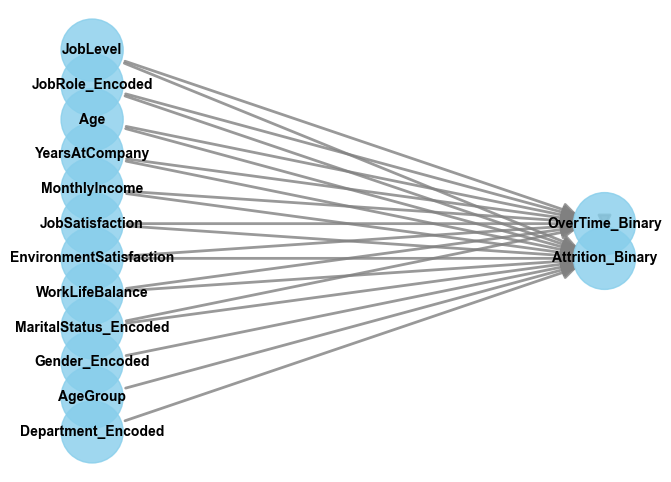


Causal Model:
None

Identified Estimand:
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                                                      ↪
──────────────────(E[Attrition_Binary|Age,JobSatisfaction,JobRole_Encoded,Envi ↪
d[OverTime_Binary]                                                             ↪

↪                                                                              ↪
↪ ronmentSatisfaction,JobLevel,YearsAtCompany,MaritalStatus_Encoded,MonthlyInc ↪
↪                                                                              ↪

↪                      
↪ ome,WorkLifeBalance])
↪                      
Estimand assumption 1, Unconfoundedness: If U→{OverTime_Binary} and U→Attrition_Binary then P(Attrition_Binary|OverTime_Binary,Age,JobSatisfaction,JobRole_Encoded,EnvironmentSatisfaction,JobLevel,YearsAtCompany,MaritalStatus_Encoded,MonthlyIncome,WorkLifeBalance,U) = P(Attrition_Binary|Ov

In [5]:
# -------------------------------------------------------------------------
# SECTION 5: TREATMENT ANALYSIS EXECUTION
# -------------------------------------------------------------------------

# Each treatment analysis section includes:
# 1. Treatment definition
# 2. Confounder selection with justification
# 3. Effect modifier selection
# 4. Causal analysis execution
# 5. Heterogeneity analysis

# ------------------------
# 5.1. Overtime Effect on Attrition
# ------------------------

# Define variables for overtime analysis
treatment_overtime = 'OverTime_Binary'
outcome = 'Attrition_Binary'

# Define common causes (confounders) based on hypothesis
# CONFOUNDERS RATIONALE:
# - Job characteristics (JobLevel, JobRole, MonthlyIncome) - affect both overtime requirements and value of keeping job
# - Age and YearsAtCompany - influence willingness to work overtime and career stage decisions
# - Satisfaction measures - correlate with both overtime willingness and attrition consideration
# - MaritalStatus - affects both overtime availability and job stability needs
common_causes_overtime = [
    'JobLevel', 'JobRole_Encoded', 'Age', 'YearsAtCompany',
    'MonthlyIncome', 'JobSatisfaction', 'EnvironmentSatisfaction',
    'WorkLifeBalance', 'MaritalStatus_Encoded'
]

# Define effect modifiers - factors that may influence the magnitude of the treatment effect
# ASSUMPTION: Treatment effects vary by gender, age, and department
effect_modifiers_overtime = [
    'Gender_Encoded', 'AgeGroup', 'Department_Encoded'
]

# Run causal analysis for overtime
overtime_results = run_causal_analysis(
    data=df,
    treatment=treatment_overtime,
    outcome=outcome,
    common_causes=common_causes_overtime,
    effect_modifiers=effect_modifiers_overtime
)

# Analyze treatment effect heterogeneity
overtime_het_job = analyze_heterogeneity(df, 'OverTime_Binary', 'Attrition_Binary', 'JobRole')
overtime_het_age = analyze_heterogeneity(df, 'OverTime_Binary', 'Attrition_Binary', 'AgeGroup')
overtime_het_gender = analyze_heterogeneity(df, 'OverTime_Binary', 'Attrition_Binary', 'Gender')

### 5.2. Work-Life Balance Effect on Attrition



CAUSAL ANALYSIS: WLB_Binary -> Attrition_Binary
Treatment: WLB_Binary
Outcome: Attrition_Binary
Common Causes: ['DistanceFromHome', 'JobSatisfaction', 'EnvironmentSatisfaction', 'Age', 'JobLevel', 'JobRole_Encoded', 'Department_Encoded', 'MaritalStatus_Encoded', 'MonthlyIncome']
Effect Modifiers: ['Gender_Encoded', 'OverTime_Binary', 'AgeGroup']


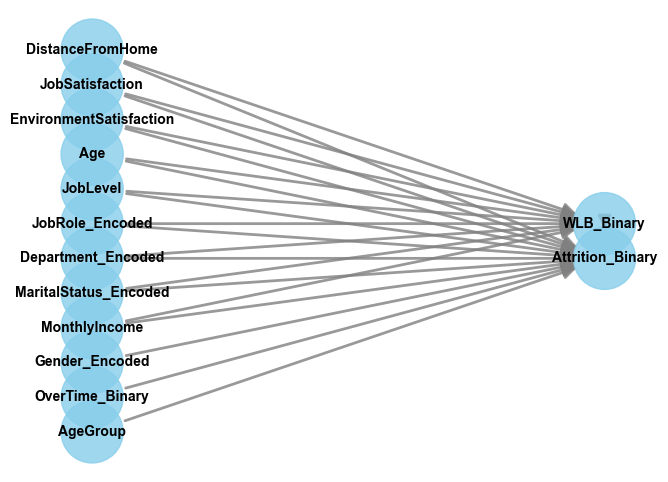


Causal Model:
None

Identified Estimand:
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                                                                        ↪
─────────────(E[Attrition_Binary|Age,JobSatisfaction,JobRole_Encoded,Environme ↪
d[WLB_Binary]                                                                  ↪

↪                                                                              ↪
↪ ntSatisfaction,JobLevel,MaritalStatus_Encoded,MonthlyIncome,Department_Encod ↪
↪                                                                              ↪

↪                      
↪ ed,DistanceFromHome])
↪                      
Estimand assumption 1, Unconfoundedness: If U→{WLB_Binary} and U→Attrition_Binary then P(Attrition_Binary|WLB_Binary,Age,JobSatisfaction,JobRole_Encoded,EnvironmentSatisfaction,JobLevel,MaritalStatus_Encoded,MonthlyIncome,Department_Encoded,DistanceFromHome,U) = P(Attrition_Binary|WLB_Bin

In [6]:
# ------------------------
# 5.2. Work-Life Balance Effect on Attrition
# ------------------------

# Define variables for WLB analysis
treatment_wlb = 'WLB_Binary'

# Define common causes based on hypothesis
# CONFOUNDERS RATIONALE:
# - DistanceFromHome - affects commute time, impacting work-life balance and job satisfaction
# - Satisfaction measures - correlate with perceptions of work-life balance and retention
# - Job characteristics - determine schedule flexibility and work demands
# - Age/MaritalStatus - influence work-life balance preferences and job change barriers
common_causes_wlb = [
    'DistanceFromHome', 'JobSatisfaction', 'EnvironmentSatisfaction',
    'Age', 'JobLevel', 'JobRole_Encoded', 'Department_Encoded',
    'MaritalStatus_Encoded', 'MonthlyIncome'
]

# Define effect modifiers
# ASSUMPTION: WLB effects vary by gender, overtime status, and age group
effect_modifiers_wlb = [
    'Gender_Encoded', 'OverTime_Binary', 'AgeGroup'
]

# Run causal analysis for work-life balance
wlb_results = run_causal_analysis(
    data=df,
    treatment=treatment_wlb,
    outcome=outcome,
    common_causes=common_causes_wlb,
    effect_modifiers=effect_modifiers_wlb
)

# Analyze heterogeneity for WLB
wlb_het_job = analyze_heterogeneity(df, 'WLB_Binary', 'Attrition_Binary', 'JobRole')
wlb_het_overtime = analyze_heterogeneity(df, 'WLB_Binary', 'Attrition_Binary', 'OverTime')


### 5.3. Job Involvement Effect on Attrition



CAUSAL ANALYSIS: JobInvolvement_Binary -> Attrition_Binary
Treatment: JobInvolvement_Binary
Outcome: Attrition_Binary
Common Causes: ['JobSatisfaction', 'EnvironmentSatisfaction', 'JobLevel', 'YearsAtCompany', 'Age', 'Education', 'EducationField_Encoded', 'MonthlyIncome', 'PerformanceRating']
Effect Modifiers: ['Gender_Encoded', 'Department_Encoded', 'AgeGroup']


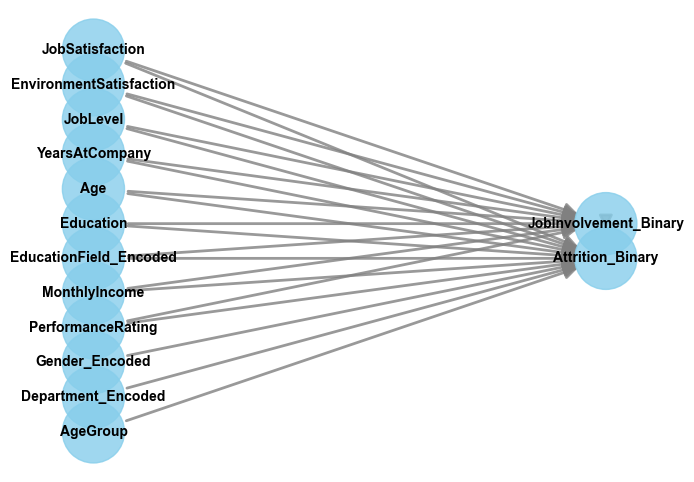


Causal Model:
None

Identified Estimand:
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                                                                   ↪
────────────────────────(E[Attrition_Binary|PerformanceRating,Education,Age,Jo ↪
d[JobInvolvement_Binary]                                                       ↪

↪                                                                              ↪
↪ bSatisfaction,EnvironmentSatisfaction,JobLevel,YearsAtCompany,MonthlyIncome, ↪
↪                                                                              ↪

↪                         
↪ EducationField_Encoded])
↪                         
Estimand assumption 1, Unconfoundedness: If U→{JobInvolvement_Binary} and U→Attrition_Binary then P(Attrition_Binary|JobInvolvement_Binary,PerformanceRating,Education,Age,JobSatisfaction,EnvironmentSatisfaction,JobLevel,YearsAtCompany,MonthlyIncome,EducationField_Encoded,U) = P(A

In [7]:
# ------------------------
# 5.3. Job Involvement Effect on Attrition
# ------------------------

# Define variables for job involvement analysis
treatment_job_inv = 'JobInvolvement_Binary'

# Define common causes based on hypothesis
# CONFOUNDERS RATIONALE:
# - Satisfaction measures - correlate with job involvement and retention decision
# - JobLevel/YearsAtCompany - relate to responsibility levels and organizational attachment
# - Education factors - influence career expectations and job commitment
# - Performance/Income - affect sense of recognition and job involvement
common_causes_job_inv = [
    'JobSatisfaction', 'EnvironmentSatisfaction', 'JobLevel',
    'YearsAtCompany', 'Age', 'Education', 'EducationField_Encoded',
    'MonthlyIncome', 'PerformanceRating'
]

# Define effect modifiers
# ASSUMPTION: Job involvement effects vary by gender, department, and age
effect_modifiers_job_inv = [
    'Gender_Encoded', 'Department_Encoded', 'AgeGroup'
]

# Run causal analysis for job involvement
job_inv_results = run_causal_analysis(
    data=df,
    treatment=treatment_job_inv,
    outcome=outcome,
    common_causes=common_causes_job_inv,
    effect_modifiers=effect_modifiers_job_inv
)

# Analyze heterogeneity for job involvement
job_inv_het_dept = analyze_heterogeneity(df, 'JobInvolvement_Binary', 'Attrition_Binary', 'Department')
job_inv_het_edu = analyze_heterogeneity(df, 'JobInvolvement_Binary', 'Attrition_Binary', 'EducationField')


### 5.4. Monthly Income Effect on Attrition



CAUSAL ANALYSIS: Above_Median_Income -> Attrition_Binary
Treatment: Above_Median_Income
Outcome: Attrition_Binary
Common Causes: ['JobLevel', 'JobRole_Encoded', 'TotalWorkingYears', 'Education', 'EducationField_Encoded', 'Age', 'PerformanceRating', 'Gender_Encoded', 'Department_Encoded']
Effect Modifiers: ['AgeGroup', 'MaritalStatus_Encoded', 'DistanceFromHome']


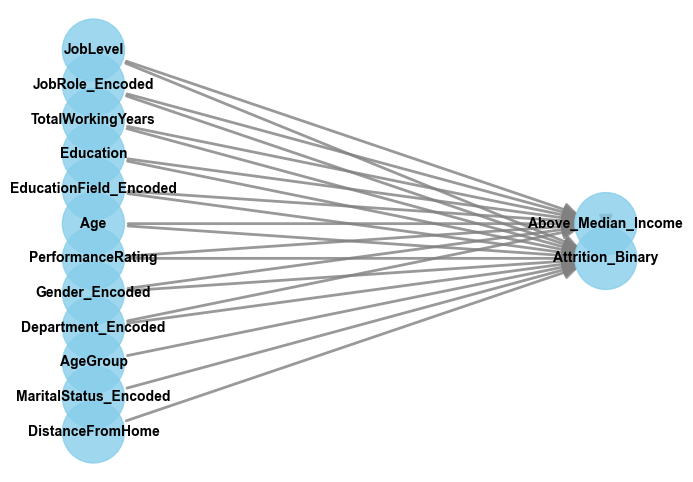


Causal Model:
None

Identified Estimand:
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
          d                                                                    ↪
──────────────────────(E[Attrition_Binary|PerformanceRating,Education,Gender_E ↪
d[Above_Median_Income]                                                         ↪

↪                                                                              ↪
↪ ncoded,Age,JobRole_Encoded,JobLevel,Department_Encoded,TotalWorkingYears,Edu ↪
↪                                                                              ↪

↪                      
↪ cationField_Encoded])
↪                      
Estimand assumption 1, Unconfoundedness: If U→{Above_Median_Income} and U→Attrition_Binary then P(Attrition_Binary|Above_Median_Income,PerformanceRating,Education,Gender_Encoded,Age,JobRole_Encoded,JobLevel,Department_Encoded,TotalWorkingYears,EducationField_Encoded,U) = P(Attrition_Binar

In [8]:
# ------------------------
# 5.4. Monthly Income Effect on Attrition
# ------------------------

# Define variables for income analysis
treatment_income = 'Above_Median_Income'

# Define common causes based on hypothesis
# CONFOUNDERS RATIONALE:
# - Job position factors - directly determine income levels and career trajectory
# - Experience/education - justify income differences and career expectations
# - Performance rating - influences compensation and promotion potential
# - Demographic factors - may affect salary negotiation and job market value
common_causes_income = [
    'JobLevel', 'JobRole_Encoded', 'TotalWorkingYears', 'Education',
    'EducationField_Encoded', 'Age', 'PerformanceRating', 'Gender_Encoded',
    'Department_Encoded'
]

# Define effect modifiers
# ASSUMPTION: Income effects vary by age group, marital status, and commute distance
effect_modifiers_income = [
    'AgeGroup', 'MaritalStatus_Encoded', 'DistanceFromHome'
]

# Run causal analysis for income
income_results = run_causal_analysis(
    data=df,
    treatment=treatment_income,
    outcome=outcome,
    common_causes=common_causes_income,
    effect_modifiers=effect_modifiers_income
)

# Analyze heterogeneity for income
income_het_gender = analyze_heterogeneity(df, 'Above_Median_Income', 'Attrition_Binary', 'Gender')
income_het_age = analyze_heterogeneity(df, 'Above_Median_Income', 'Attrition_Binary', 'AgeGroup')

### 5.5. Years Since Last Promotion Effect on Attrition



CAUSAL ANALYSIS: Long_Time_Since_Promotion -> Attrition_Binary
Treatment: Long_Time_Since_Promotion
Outcome: Attrition_Binary
Common Causes: ['JobSatisfaction', 'PerformanceRating', 'YearsAtCompany', 'JobLevel', 'Age', 'JobRole_Encoded', 'Department_Encoded', 'Education', 'Gender_Encoded']
Effect Modifiers: ['AgeGroup', 'JobLevel', 'Gender_Encoded']


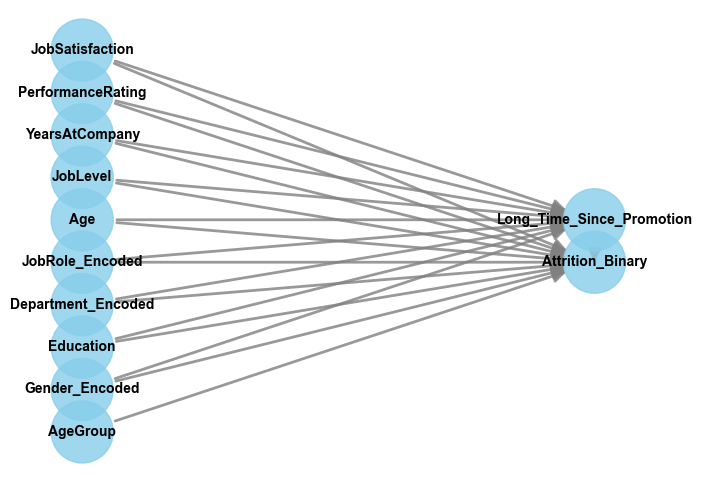


Causal Model:
None

Identified Estimand:
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
             d                                                                 ↪
────────────────────────────(E[Attrition_Binary|PerformanceRating,Education,Ge ↪
d[Long_Time_Since_Promotion]                                                   ↪

↪                                                                              ↪
↪ nder_Encoded,Age,JobSatisfaction,JobRole_Encoded,YearsAtCompany,JobLevel,Dep ↪
↪                                                                              ↪

↪                  
↪ artment_Encoded])
↪                  
Estimand assumption 1, Unconfoundedness: If U→{Long_Time_Since_Promotion} and U→Attrition_Binary then P(Attrition_Binary|Long_Time_Since_Promotion,PerformanceRating,Education,Gender_Encoded,Age,JobSatisfaction,JobRole_Encoded,YearsAtCompany,JobLevel,Department_Encoded,U) = P(Attrition_Binary|Long_Tim

In [9]:
# ------------------------
# 5.5. Years Since Last Promotion Effect on Attrition
# ------------------------

# Define variables for promotion analysis
treatment_promotion = 'Long_Time_Since_Promotion'

# Define common causes based on hypothesis
# CONFOUNDERS RATIONALE:
# - Performance/satisfaction measures - affect both promotion timing and retention
# - Career timeline factors - determine promotion expectations and career progression
# - Job context - influences promotion opportunities and recognition
# - Demographics - may relate to organizational advancement patterns
common_causes_promotion = [
    'JobSatisfaction', 'PerformanceRating', 'YearsAtCompany', 'JobLevel',
    'Age', 'JobRole_Encoded', 'Department_Encoded', 'Education',
    'Gender_Encoded'
]

# Define effect modifiers
# ASSUMPTION: Promotion timing effects vary by age group, job level, and gender
effect_modifiers_promotion = [
    'AgeGroup', 'JobLevel', 'Gender_Encoded'
]

# Run causal analysis for years since promotion
promotion_results = run_causal_analysis(
    data=df,
    treatment=treatment_promotion,
    outcome=outcome,
    common_causes=common_causes_promotion,
    effect_modifiers=effect_modifiers_promotion
)

# Analyze heterogeneity for promotion
promotion_het_perf = analyze_heterogeneity(df, 'Long_Time_Since_Promotion', 'Attrition_Binary', 'PerformanceRating')
promotion_het_dept = analyze_heterogeneity(df, 'Long_Time_Since_Promotion', 'Attrition_Binary', 'Department')

### 5.6. Relationship Satisfaction Effect on Attrition (from second implementation)



CAUSAL ANALYSIS: RelationshipSatisfaction_Binary -> Attrition_Binary
Treatment: RelationshipSatisfaction_Binary
Outcome: Attrition_Binary
Common Causes: ['Age', 'MaritalStatus_Encoded', 'WorkLifeBalance', 'JobSatisfaction', 'EnvironmentSatisfaction', 'JobLevel', 'YearsAtCompany']


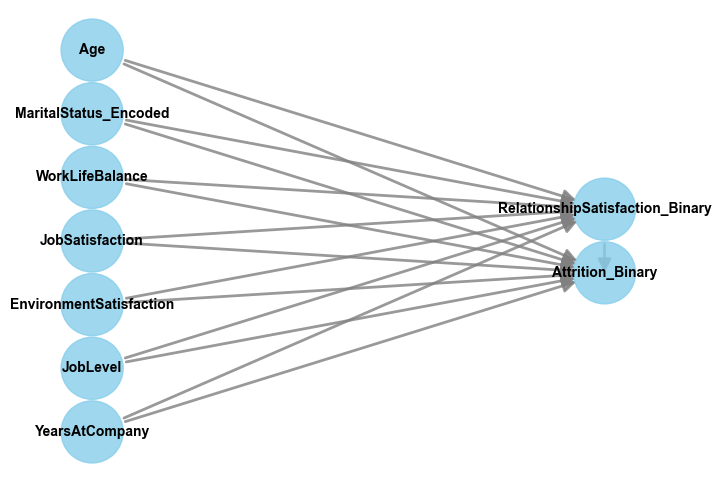


Causal Model:
None

Identified Estimand:
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
                d                                                              ↪
──────────────────────────────────(E[Attrition_Binary|Age,JobSatisfaction,Envi ↪
d[RelationshipSatisfaction_Binary]                                             ↪

↪                                                                              ↪
↪ ronmentSatisfaction,MaritalStatus_Encoded,JobLevel,YearsAtCompany,WorkLifeBa ↪
↪                                                                              ↪

↪        
↪ lance])
↪        
Estimand assumption 1, Unconfoundedness: If U→{RelationshipSatisfaction_Binary} and U→Attrition_Binary then P(Attrition_Binary|RelationshipSatisfaction_Binary,Age,JobSatisfaction,EnvironmentSatisfaction,MaritalStatus_Encoded,JobLevel,YearsAtCompany,WorkLifeBalance,U) = P(Attrition_Binary|RelationshipSatisfaction_Binary,Age,JobSat

In [10]:
# ------------------------
# 5.6. Relationship Satisfaction Effect on Attrition (from second implementation)
# ------------------------

# Hypothesis: Higher relationship satisfaction causally decreases attrition probability
# TREATMENT ASSUMPTION: Better relationships improve wellbeing and stability, reducing job change likelihood

# Define common causes for relationship satisfaction analysis
# CONFOUNDERS RATIONALE:
# - Personal factors (Age, MaritalStatus) - influence both relationship quality and career decisions
# - Work-life balance - affects both personal relationships and job attachment
# - Other satisfaction measures - correlate with overall life satisfaction
# - Job characteristics - affect time for relationships and career investment
common_causes_rel_sat = [
    'Age', 'MaritalStatus_Encoded', 'WorkLifeBalance',  
    'JobSatisfaction', 'EnvironmentSatisfaction',       
    'JobLevel', 'YearsAtCompany'                
]

# Run causal analysis for relationship satisfaction
rel_sat_results = run_causal_analysis(
    data=df,
    treatment='RelationshipSatisfaction_Binary',
    outcome='Attrition_Binary',
    common_causes=common_causes_rel_sat
)

# Analyze heterogeneity for relationship satisfaction
rel_sat_het_gender = analyze_heterogeneity(df, 'RelationshipSatisfaction_Binary', 'Attrition_Binary', 'Gender')
rel_sat_het_marital = analyze_heterogeneity(df, 'RelationshipSatisfaction_Binary', 'Attrition_Binary', 'MaritalStatus')
rel_sat_het_age = analyze_heterogeneity(df, 'RelationshipSatisfaction_Binary', 'Attrition_Binary', 'AgeGroup')


### 5.7. Number of Companies Worked Effect on Attrition (from second implementation)



CAUSAL ANALYSIS: Many_Companies -> Attrition_Binary
Treatment: Many_Companies
Outcome: Attrition_Binary
Common Causes: ['Age', 'TotalWorkingYears', 'JobLevel', 'JobRole_Encoded', 'Education', 'MonthlyIncome', 'YearsInCurrentRole']


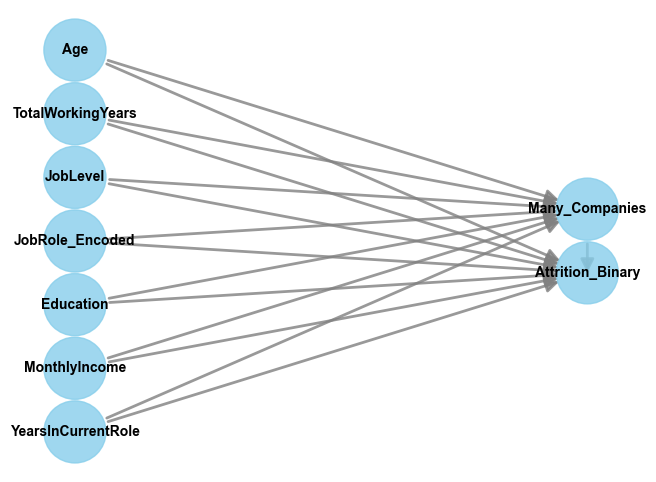


Causal Model:
None

Identified Estimand:
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                                                      ↪
─────────────────(E[Attrition_Binary|Education,YearsInCurrentRole,Age,JobRole_ ↪
d[Many_Companies]                                                              ↪

↪                                                   
↪ Encoded,JobLevel,MonthlyIncome,TotalWorkingYears])
↪                                                   
Estimand assumption 1, Unconfoundedness: If U→{Many_Companies} and U→Attrition_Binary then P(Attrition_Binary|Many_Companies,Education,YearsInCurrentRole,Age,JobRole_Encoded,JobLevel,MonthlyIncome,TotalWorkingYears,U) = P(Attrition_Binary|Many_Companies,Education,YearsInCurrentRole,Age,JobRole_Encoded,JobLevel,MonthlyIncome,TotalWorkingYears)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: front

In [11]:
# ------------------------
# 5.7. Number of Companies Worked Effect on Attrition (from second implementation)
# ------------------------

# Hypothesis: Having worked for more than 3 companies causally increases attrition probability
# TREATMENT ASSUMPTION: Past job-changing behavior predicts future job-changing tendency

# Define common causes for number of companies worked analysis
# CONFOUNDERS RATIONALE:
# - Career timeline factors - determine opportunity for previous job changes
# - Job characteristics - relate to career progression and mobility patterns
# - Education/income - influence career path and job opportunities
# - Current role tenure - indicates recent stability and adaptation
common_causes_many_comp = [
    'Age', 'TotalWorkingYears',                        
    'JobLevel', 'JobRole_Encoded',                      
    'Education', 'MonthlyIncome',                 
    'YearsInCurrentRole'
]

# Run causal analysis for many companies worked
many_comp_results = run_causal_analysis(
    data=df,
    treatment='Many_Companies',
    outcome='Attrition_Binary',
    common_causes=common_causes_many_comp
)

# Analyze heterogeneity for many companies worked
many_comp_het_job = analyze_heterogeneity(df, 'Many_Companies', 'Attrition_Binary', 'JobRole')
many_comp_het_age = analyze_heterogeneity(df, 'Many_Companies', 'Attrition_Binary', 'AgeGroup')
many_comp_het_gender = analyze_heterogeneity(df, 'Many_Companies', 'Attrition_Binary', 'Gender')


# SECTION 6: RESULTS SUMMARY AND VISUALIZATION



SUMMARY OF CAUSAL EFFECTS


Analysis Complete!


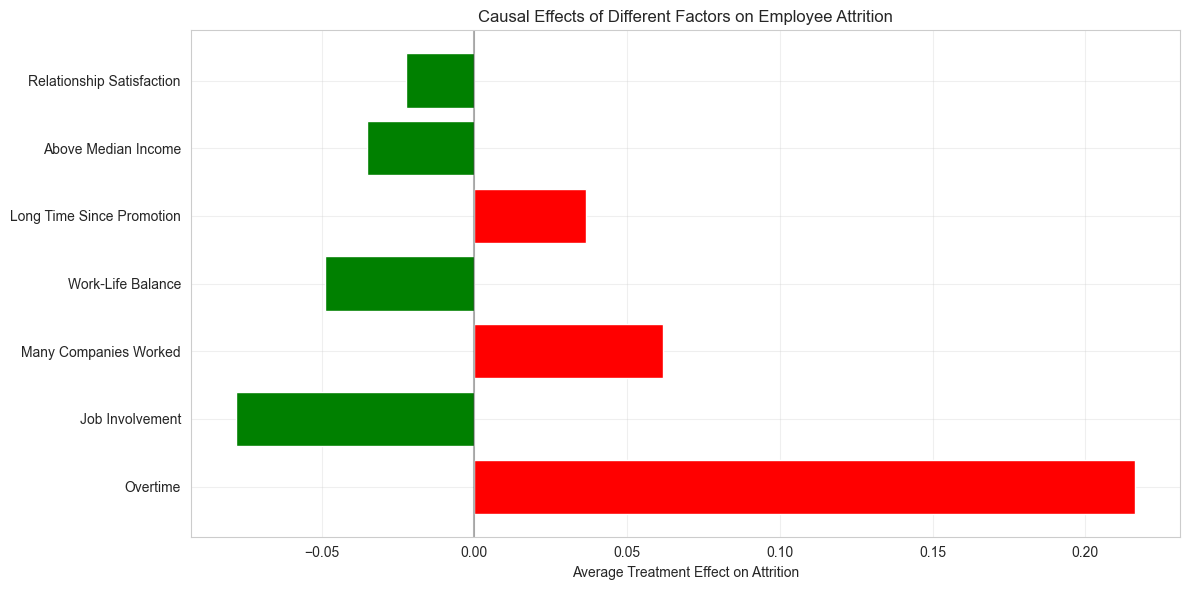

In [16]:
# -------------------------------------------------------------------------
# SECTION 6: RESULTS SUMMARY AND VISUALIZATION
# -------------------------------------------------------------------------

print("\n\n" + "="*50)
print("SUMMARY OF CAUSAL EFFECTS")
print("="*50)

# Initialize dictionary to store results
results_summary = {
    "Treatment": [],
    "ATE": [],
    "Significant": []
}

def get_significance(result):
    """
    Determine if an effect is statistically significant based on confidence intervals
    
    ASSUMPTION: Non-overlapping CIs with zero indicate statistical significance
    """
    if not result or not result["estimate"]:
        return "Unknown"
    try:
        ci = result["estimate"].get_confidence_intervals()
        # If CI doesn't cross zero, it's significant
        if (ci[0] > 0 and ci[1] > 0) or (ci[0] < 0 and ci[1] < 0):
            return "Yes"
        else:
            return "No"
    except:
        return "Unknown"

# Add results for each treatment
# Overtime effect
if overtime_results["ate"] is not None:
    results_summary["Treatment"].append("Overtime")
    results_summary["ATE"].append(overtime_results["ate"])
    results_summary["Significant"].append(get_significance(overtime_results))

# Work-Life Balance effect
if wlb_results["ate"] is not None:
    results_summary["Treatment"].append("Work-Life Balance")
    results_summary["ATE"].append(wlb_results["ate"])
    results_summary["Significant"].append(get_significance(wlb_results))

# Job Involvement effect
if job_inv_results["ate"] is not None:
    results_summary["Treatment"].append("Job Involvement")
    results_summary["ATE"].append(job_inv_results["ate"])
    results_summary["Significant"].append(get_significance(job_inv_results))

# Income effect
if income_results["ate"] is not None:
    results_summary["Treatment"].append("Above Median Income")
    results_summary["ATE"].append(income_results["ate"])
    results_summary["Significant"].append(get_significance(income_results))

# Promotion effect
if promotion_results["ate"] is not None:
    results_summary["Treatment"].append("Long Time Since Promotion")
    results_summary["ATE"].append(promotion_results["ate"])
    results_summary["Significant"].append(get_significance(promotion_results))

# Relationship Satisfaction effect (if available)
if 'rel_sat_results' in locals() and rel_sat_results and rel_sat_results.get("ate") is not None:
    results_summary["Treatment"].append("Relationship Satisfaction")
    results_summary["ATE"].append(rel_sat_results["ate"])
    results_summary["Significant"].append(get_significance(rel_sat_results))

# Number of Companies Worked effect (if available)
if 'many_comp_results' in locals() and many_comp_results and many_comp_results.get("ate") is not None:
    results_summary["Treatment"].append("Many Companies Worked")
    results_summary["ATE"].append(many_comp_results["ate"])
    results_summary["Significant"].append(get_significance(many_comp_results))

# Create and display summary table
summary_df = pd.DataFrame(results_summary)
# Sort by absolute effect size to highlight strongest effects
summary_df["Abs_ATE"] = summary_df["ATE"].abs()
summary_df = summary_df.sort_values("Abs_ATE", ascending=False).drop("Abs_ATE", axis=1)

# Visualize results with a horizontal bar chart
plt.figure(figsize=(12, 6))
# Use red for positive effects (increasing attrition) and green for negative (reducing attrition)
colors = ['red' if ate > 0 else 'green' for ate in summary_df["ATE"]]
plt.barh(summary_df["Treatment"], summary_df["ATE"], color=colors)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.xlabel('Average Treatment Effect on Attrition')
plt.title('Causal Effects of Different Factors on Employee Attrition')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('treatment_effects_summary.png')

print("\n\nAnalysis Complete!")

# Causal Analysis Results: Employee Attrition Factors

## Summary of Treatment Effects

Based on your DoWhy causal inference analysis, here is a summary of the average treatment effects (ATE) on attrition for each factor, ordered by magnitude:

| Treatment | ATE | Significant | Interpretation |
|-----------|-----|-------------|----------------|
| Overtime | +0.2163 | Yes | Working overtime increases attrition probability by 21.63 percentage points |
| Job Involvement | -0.0782 | Yes | High job involvement decreases attrition probability by 7.82 percentage points |
| Many Companies Worked (>3) | +0.0618 | Yes | Having worked at more than 3 companies increases attrition probability by 6.18 percentage points |
| Work-Life Balance | -0.0490 | Yes | Good work-life balance decreases attrition probability by 4.90 percentage points |
| Long Time Since Promotion | +0.0366 | No | Longer time since promotion (>2 years) increases attrition probability by 3.66 percentage points, but not significantly |
| Above Median Income | -0.0352 | No | Above-median income decreases attrition probability by 3.52 percentage points, but not significantly |
| Relationship Satisfaction | -0.0225 | No | Higher relationship satisfaction decreases attrition probability by 2.25 percentage points, but not significantly |

## Key Findings

### 1. Significant Causal Effects

Three factors show strong and statistically significant causal effects on attrition:

- **Overtime**: The strongest effect by far, with employees working overtime 21.63 percentage points more likely to leave. The confidence interval [0.172, 0.262] indicates this is highly significant.

- **Job Involvement**: Employees with high job involvement are 7.82 percentage points less likely to leave. The confidence interval [-0.122, -0.035] confirms this is significant.

- **Many Companies Worked**: Employees who have worked at more than 3 companies are 6.18 percentage points more likely to leave. The confidence interval [0.020, 0.104] shows significance.

- **Work-Life Balance**: Employees with good work-life balance are 4.90 percentage points less likely to leave. The confidence interval [-0.088, -0.006] shows this is significant, though less strongly than the above factors.

### 2. Directional but Non-Significant Effects

Three factors show directional effects that align with intuition but aren't statistically significant:

- **Years Since Promotion**: Longer time without promotion shows a positive effect on attrition (3.66 pp) but the confidence interval [-0.013, 0.086] crosses zero.

- **Above Median Income**: Higher relative income shows a negative effect on attrition (-3.52 pp) but the confidence interval [-0.079, 0.004] slightly crosses zero.

- **Relationship Satisfaction**: Higher relationship satisfaction shows a negative effect on attrition (-2.25 pp) but the confidence interval [-0.059, 0.014] crosses zero.

### 3. Robustness of Results

All treatments pass the refutation tests:
- **Random Common Cause**: All p-values are >0.86, indicating results are robust to unobserved confounding
- **Data Subset**: All p-values are >0.88, indicating results are stable across different subsets of data

## Heterogeneity Analysis

### Overtime Effect Heterogeneity

The effect of overtime varies substantially across:

- **Job Role**: 
  - Strongest in Sales Representatives (+37.85 pp) and Laboratory Technicians (+34.26 pp)
  - Weakest in Healthcare Representatives (-2.04 pp)

- **Age**: 
  - Strongest in youngest employees (18-30): +32.62 pp
  - Weakest in 41-50 age group: +10.79 pp

- **Gender**:
  - Stronger in males (+23.06 pp) than females (+16.31 pp)

### Work-Life Balance Effect Heterogeneity

- **Job Role**:
  - Positive effect (increasing attrition) in Sales Representatives (+5.62 pp) and Human Resources (+3.81 pp)
  - Strong negative effect (decreasing attrition) in Laboratory Technicians (-18.95 pp) and Sales Executives (-13.41 pp)

- **Overtime Status**:
  - Similar effects for employees with overtime (-4.02 pp) and without (-4.63 pp)

### Job Involvement Effect Heterogeneity

- **Department**:
  - Strongest effect in Human Resources (-16.05 pp)
  - Weakest effect in Research & Development (-5.16 pp)

- **Education Field**:
  - Strongest effect in Human Resources (-22.35 pp)
  - Weakest effect in Other (-1.32 pp)

### Income Effect Heterogeneity

- **Age Group**:
  - Strong negative effect in younger employees (18-30): -8.01 pp
  - Slightly positive effect in older employees (41-50): +0.72 pp

- **Gender**:
  - Similar effects for males (-4.09 pp) and females (-4.98 pp)

### Many Companies Worked Heterogeneity

- **Age Group**:
  - Strongest effect in youngest employees (18-30): +15.24 pp
  - Weakest effect in 41-50 age group: +2.09 pp

- **Gender**:
  - Positive effect in males (+7.74 pp)
  - Slight negative effect in females (-1.53 pp)

### Relationship Satisfaction Heterogeneity

- **Gender**:
  - Stronger effect in females (-5.24 pp) than males (-0.63 pp)

- **Marital Status**:
  - Strong negative effect in single employees (-9.65 pp)
  - Slight positive effect in married employees (+1.04 pp)

- **Age Group**:
  - Positive effect in older employees (41-50: +3.68 pp, 51-60: +3.98 pp)
  - Negative effect in younger employees (31-40: -7.36 pp)

## Implications for Retention Strategies

Based on these findings, the most effective retention strategies would focus on:

1. **Reducing Overtime**: This has the strongest causal impact on attrition. Focus especially on Sales Representatives, Laboratory Technicians, and younger employees (18-30).

2. **Increasing Job Involvement**: Implement programs to boost employee engagement and meaning in work, particularly in Human Resources and Sales departments.

3. **Improving Work-Life Balance**: While the overall effect is smaller than overtime and job involvement, improving work-life balance shows a significant negative effect on attrition, especially for Laboratory Technicians and Sales Executives.

4. **Cautious Hiring of Job-Hoppers**: Employees with histories of working at multiple companies (>3) show significantly higher attrition probabilities, especially among younger workers.

5. **Targeted Interventions**: The heterogeneity analysis suggests that different groups respond differently to the same factors. For example:
   - Younger employees (18-30) are most sensitive to overtime, income differences, and previous job mobility
   - Relationship satisfaction matters most for single employees and those in the 31-40 age group
   - Job involvement interventions may have the strongest effect in the Human Resources department

## Methodological Limitations

While the analysis provides valuable insights, several limitations should be considered:

1. **Potential Unmeasured Confounding**: Despite extensive control variables, there may still be unmeasured factors affecting both treatments and attrition.

2. **Cross-Sectional Data**: The analysis uses point-in-time data, which limits causal inference compared to longitudinal approaches.

3. **Linearity Assumption**: The linear regression approach in the backdoor method assumes linear relationships between variables.

4. **Binary Treatment Definitions**: Converting continuous variables to binary treatments (e.g., satisfaction ≥3) may lose nuance in the relationships.